In [1]:
%matplotlib inline
import os
import numpy as np
import scipy as sp
import scipy.optimize
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import rc
from astroML.plotting import setup_text_plots
import pdb
setup_text_plots(fontsize=25, usetex=True)

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rcParams['font.size'] = 25.0

# Define `Telescope` and `Planet` classes 

In [2]:
class Telescope(object):
    
    '''
    Parameters
    ----------
    
    lammin : float
        Minimum wavelength (um)
    lammax : float 
        Maximum wavelength (um)
    R : float 
        Spectral resolution (lambda / delta-lambda)
    Tsys : float 
        Telescope temperature (K)
    D : float
        Telescope diameter (m) 
    emis : float 
        Telescope emissivity
    IWA : float
        Inner Working Angle (lambda/D)
    OWA : float 
        Outer Working Angle (lambda/D)
    Tput : float 
        Telescope throughput   
    C : float 
        Raw Contrast
    De : float 
        Dark current (s**-1)
    DNHpix : float
        Horizontal pixel spread of IFS spectrum
    Re : float 
        Read noise per pixel
    Dtmax : float
        Maximum exposure time (hr)
    X : float
        Size of photometric aperture (lambda/D)
    q : float
        Quantum efficiency
    '''
    
    # Define a constructor
    def __init__(self, lammin=0.3,lammax=2.0,R=70.,Tput=0.2,\
                 D=8.0,Tsys=274.,IWA=0.5, OWA=30000.,emis=0.9,\
                 C=1e-10,De=1e-4,DNHpix=3.,Re=0.1,Dtmax=1.0,X=0.7,q=0.9):
        
        self.lammin=lammin
        self.lammax=lammax
        self.resolution=R
        self.throughput=Tput
        self.diameter=D
        self.temperature=Tsys
        self.IWA=IWA
        self.OWA=OWA
        self.emissivity=emis
        self.contrast=C
        
        self.darkcurrent=De
        self.DNHpix=DNHpix
        self.readnoise=Re
        self.Dtmax=Dtmax
        self.X=X
        self.qe=q
    
    def __str__(self):
        string = 'Coronagraph: \n------------\n'+\
            '- Minimum wavelength (um) : '+"%s" % (self.lammin)+'\n'+\
            '- Maximum wavelength (um)  : '+"%s" % (self.lammax)+'\n'+\
            '- Spectral resolution (lambda / delta-lambda)  : '+"%s" % (self.resolution)+' \n'+\
            '- Telescope temperature (K)  : '+"%s" % (self.temperature)+' \n'+\
            '- Telescope diameter (m)  : '+"%s" % (self.diameter)+' \n'+\
            '- Telescope emissivity  : '+"%s" % (self.emissivity)+' \n'+\
            '- Inner Working Angle (lambda/D)  : '+"%s" % (self.IWA)+' \n'+\
            '- Outer Working Angle (lambda/D)  : '+"%s" % (self.OWA)+' \n'+\
            '- Telescope throughput  : '+"%s" % (self.throughput)+' \n'+\
            '- Raw Contrast  : '+"%s" % (self.contrast)+' \n'+\
            '- Dark current (s**-1)  : '+"%s" % (self.darkcurrent)+' \n'+\
            '- Horizontal pixel spread of IFS spectrum  : '+"%s" % (self.DNHpix)+' \n'+\
            '- Read noise per pixel  : '+"%s" % (self.readnoise)+' \n'+\
            '- Maximum exposure time (hr)  : '+"%s" % (self.Dtmax)+' \n'+\
            '- Size of photometric aperture (lambda/D)  : '+"%s" % (self.X)+' \n'+\
            '- Quantum efficiency  : '+"%s" % (self.qe)+''
        return string

In [3]:
import numpy as np

def lambertPhaseFunction(alpha):
    '''Calculate the Lambertian Phase Function from the phase angle.
    Args:
        alpha: Planet phase angle (degrees)
    Returns:
        The Lambertian phase function
    '''
    alpha = alpha * np.pi / 180.
    return (np.sin(alpha) + (np.pi - alpha) * np.cos(alpha)) / np.pi

class Planet(object):
    '''Parameters of the planet to be observed.
    
    Parameters
    ----------
    
    name : string
        Planet name from database
    star : string
        Stellar type of planet host star
    d : float
        Distance to system (pc)
    Nez : float
        Number of exzodis (zodis)
    Rp : float
        Radius of planet (Earth Radii)
    a : float
        Semi-major axis (AU)
    alpha : float
        Phase angle (deg)
    Phi : float
        Lambertian phase function
    MzV : float
        Zodiacal light surface brightness (mag/arcsec**2)
    MezV : float
        exozodiacal light surface brightness (mag/arcsec**2)
    '''
    
    # Define a constructor
    def __init__(self, name='earth', star='sun', d=10.0,Nez=1.0,\
                 Rp=1.0, a=1.0, alpha=90.,\
                 MzV=23.0, MezV=22.0):
        self.name=name
        self.star=star
        self.distance=d
        self.Nez=Nez
        self.Rp=Rp
        self.a=a
        self._alpha=alpha
        self._Phi = None
        self.MzV  = MzV     # zodiacal light surface brightness (mag/arcsec**2)
        self.MezV = MezV     # exozodiacal light surface brightness (mag/arcsec**2)
        
        if self._Phi is None:
            self._Phi = lambertPhaseFunction(self._alpha)
        else:
            raise Exception("Error in Planet Phase Function (Phi)")
  
    @property
    def alpha(self):
        return self._alpha
  
    @alpha.setter
    def alpha(self, value):
        self._alpha = value
        self._Phi = lambertPhaseFunction(value)
  
    @property
    def Phi(self):
        return self._Phi
  
    @Phi.setter
    def Phi(self, value):
        self._Phi = value

    def __str__(self):
        string = 'Planet: \n-------\n'+\
            '- Planet name  : '+"%s" % (self.name)+'\n'+\
            '- Stellar type of planet host star : '+"%s" % (self.star)+'\n'+\
            '- Distance to system (pc) : '+"%s" % (self.distance)+'\n'+\
            '- Number of exzodis (zodis) : '+"%s" % (self.Nez)+'\n'+\
            '- Radius of planet (Earth Radii) : '+"%s" % (self.Rp)+'\n'+\
            '- Semi-major axis (AU) : '+"%s" % (self.a)+'\n'+\
            '- Phase angle (deg) : '+"%s" % (self.alpha)+'\n'+\
            '- Lambertian phase function : '+"%s" % (self.Phi)+'\n'+\
            '- Zodiacal light surface brightness (mag/arcsec**2) : '+"%s" % (self.MzV)+'\n'+\
            '- Exozodiacal light surface brightness (mag/arcsec**2) : '+"%s" % (self.MezV)
        return string

In [4]:
class Star(object):
    
    def __init__(self, Teff=5780.0, Rs=1.0):
        self.Teff=Teff
        self.Rs=Rs
    
    def __str__(self):
        string = 'Star: \n-----\n'+\
            '- Effective Temperature (K)  : '+"%s" % (self.Teff)+'\n'+\
            '- Radius (Solar Radii) : '+"%s" % (self.Rs)
        return string

In [5]:
T = Telescope()
P = Planet()
S = Star()

In [6]:
print T

Coronagraph: 
------------
- Minimum wavelength (um) : 0.3
- Maximum wavelength (um)  : 2.0
- Spectral resolution (lambda / delta-lambda)  : 70.0 
- Telescope temperature (K)  : 274.0 
- Telescope diameter (m)  : 8.0 
- Telescope emissivity  : 0.9 
- Inner Working Angle (lambda/D)  : 0.5 
- Outer Working Angle (lambda/D)  : 30000.0 
- Telescope throughput  : 0.2 
- Raw Contrast  : 1e-10 
- Dark current (s**-1)  : 0.0001 
- Horizontal pixel spread of IFS spectrum  : 3.0 
- Read noise per pixel  : 0.1 
- Maximum exposure time (hr)  : 1.0 
- Size of photometric aperture (lambda/D)  : 0.7 
- Quantum efficiency  : 0.9


In [7]:
print P.Phi
P.alpha = 45.
print P.Phi

0.318309886184
0.755409164929


In [8]:
print S

Star: 
-----
- Effective Temperature (K)  : 5780.0
- Radius (Solar Radii) : 1.0


In [9]:
def call_atlast_noise(telescope,planet,Ahr='',lamhr=''):
    '''
    (Ahr='', lamhr='', planet='earth', startype='sun', \
    lammin=0.3,lammax=2.0, Res=70., Tput=0.2, diam=8.0, Tsys=274.,\
    IWA=0.5, OWA=30000., d=10., Nez=1., emis=0.9, wantsnr=10.,\
    C=1.e-10, alpha=90., Phi=1./np.pi, planetdir='planets/', \
    Rp=1.0, r=1.0):
    '''
    '''
    planet choices: 
        earth, venus, archean,
        earlymars, hazyarchean, earlyvenus,
        jupiter, saturn, uranus, neptune, mars,
        fstarozone
    star choices (for now):
    sun, f2v
    '''

    whichplanet = planet.name
    startype = planet.star
    planetdir = '../planets/'

    if Ahr == '' and lamhr == '':
        
        if whichplanet == 'earth':
            fn = 'earth_quadrature_radiance_refl.dat'
            model = np.loadtxt(planetdir+fn, skiprows=8)
            lamhr = model[:,0] 
            radhr = model[:,1] 
            solhr = model[:,2] 
            reflhr = model[:,3]
            Ahr   = np.pi*(np.pi*radhr/solhr) # hi-resolution reflectivity
            planet.Rp    = 1.0     # Earth radii
            planet.r     = 1.0     # semi-major axis (AU) 

        if whichplanet == 'venus':
            fn = pldir+'Venus_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 0.95     #Earth radii
            planet.r     = 0.72     #semi-major axis (AU)

        if whichplanet == 'archean':
            fn = pldir+'ArcheanEarth_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]     	
            planet.Rp    = 1.0     #Earth radii
            planet.r     = 1.0     #semi-major axis (AU)

        if whichplanet == 'earlymars':
            fn = pldir+'EarlyMars_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 0.53     #Earth radii
            planet.r     = 1.52     #semi-major axis (AU)

        if whichplanet == 'hazyarchean':
            fn = pldir+'Hazy_ArcheanEarth_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]     	
            planet.Rp    = 1.0     #Earth radii
            planet.r     = 1.0     #semi-major axis (AU)

        if whichplanet == 'earlyvenus':
            fn = pldir+'EarlyVenus_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 0.95     #Earth radii
            planet.r     = 0.72     #semi-major axis (AU)

        if whichplanet == 'jupiter':
            fn = pldir+'Jupiter_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 10.86     #Earth radii
            planet.r     = 5.20     #semi-major axis (AU)

        if whichplanet == 'saturn':
            fn = pldir+'Saturn_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 9.00     #Earth radii
            planet.r     = 9.54     #semi-major axis (AU)

        if whichplanet == 'uranus':
            fn = pldir+'Uranus_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 3.97     #Earth radii
            planet.r     = 19.19     #semi-major axis (AU)


        if whichplanet == 'warmuranus':
            fn = pldir+'Uranus_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 3.97     #Earth radii
            planet.r     = 5.20     #semi-major axis (AU)
        
        if whichplanet == 'warmneptune':
            fn = pldir+'Neptune_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 3.97     #Earth radii
            planet.r     = 5.20     #semi-major axis (AU)

        if whichplanet == 'neptune':
            fn = pldir+'Neptune_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 3.85     #Earth radii
            planet.r     = 30.07     #semi-major axis (AU)


        if whichplanet == 'mars':
            fn = pldir+'Mars_geo_albedo.txt'
            model = np.loadtxt(planetdir+fn) 
            lamhr = model[:,0] 
            Ahr   = model[:,1]
            planet.Rp    = 0.53     #Earth radii
            planet.r     = 1.52     #semi-major axis (AU)

        if whichplanet == 'fstarozone':
            print('fstarozone functionality not yet added') 
            #fn = 'fstarcloudy.sav'
            #fn = 'F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad'
            #READCOL, 'planets/'+fn, lamhr, wnhr, sunhr, fluxhr
            #restore, 'planets/'+fn
            #lamhr = reverse(wl_)
            #ahr = reverse(cloudyalb_)
            #Ahr = (2/3.) * fluxhr/(sunhr/2.) #geometric albedo & phase corrections
            #Rp    = 1.0     #Earth radii
            #r     = 1.72    #semi-major axis (AU)



    # star parameters
    if startype == '':
        Teff  = 5780.   #Sun-like Teff (K)
        Rs    = 1.      #star radius in solar radii
    if  startype == 'sun':
        Teff  = 5780.   #Sun-like Teff (K)
        Rs    = 1.      #star radius in solar radii
    if  startype == 'f2v':
        Teff  = 7050.   #Sun-like Teff (K)
        Rs    = 1.3      #star radius in solar radii
    
    star = Star(Teff=Teff, Rs=Rs)
 
    # Shawn: "I don't like noise.  It makes me sad."

    lam, dlam, A, q, Cratio, cp, csp, cz, cez, cD, cR, cth, DtSNR \
        = atlast_noise(Ahr, lamhr, telescope, planet, star, COMPUTE_LAM=True)

    return lam, dlam, A, q, Cratio, cp, csp, cz, cez, cD, cR, cth, DtSNR

In [10]:
def atlast_noise(Ahr, lamhr, telescope, planet, star, wantsnr=10.0, FIX_OWA = False, COMPUTE_LAM = False,\
    SILENT = False):
    
    # Assign Class attributes to local variables
    alpha = planet.alpha
    Phi = planet.Phi
    Rp = planet.Rp
    Teff = star.Teff
    Rs=star.Rs
    r=planet.a
    d=planet.distance
    Nez=planet.Nez
    lammin=telescope.lammin
    lammax=telescope.lammax
    Res=telescope.resolution
    diam=telescope.diameter
    Tput=telescope.throughput
    C=telescope.contrast
    IWA=telescope.IWA
    OWA=telescope.OWA
    Tsys=telescope.temperature
    emis=telescope.emissivity

    # Set key system parameters
    De     = telescope.darkcurrent  # dark current (s**-1)
    DNHpix = telescope.DNHpix       # horizontal pixel spread of IFS spectrum
    Re     = telescope.readnoise    # read noise per pixel
    Dtmax  = telescope.Dtmax        # maximum exposure time (hr)
    X      = telescope.X            # size of photometric aperture (lambda/D)
    q      = telescope.qe           # quantum efficiency
  
    # Set astrophysical parameters
    MzV  = 23.0     # zodiacal light surface brightness (mag/arcsec**2)
    MezV = 22.0     # exozodiacal light surface brightness (mag/arcsec**2)

    # Compute angular size of lenslet
    theta = lammin/1.e6/diam/2.*(180/np.pi*3600.) #assumes sampled at ~lambda/2D (arcsec)

    # Set wavelength grid
    if COMPUTE_LAM:
        lam  = lammin #in [um]
        Nlam = 1
        while (lam < lammax):
            lam  = lam + lam/Res
            Nlam = Nlam +1 
        lam    = np.zeros(Nlam)
        lam[0] = lammin
        for j in range(1,Nlam):
            lam[j] = lam[j-1] + lam[j-1]/Res
    Nlam = len(lam)
    dlam = np.zeros(Nlam) #grid widths (um)
    for j in range(1,Nlam-1):
        dlam[j] = 0.5*(lam[j+1]+lam[j]) - 0.5*(lam[j-1]+lam[j])
    #widths at edges are same as neighbor
    dlam[0] = dlam[1]
    dlam[Nlam-1] = dlam[Nlam-2]

    # Set throughput      
    T    = np.zeros(Nlam)
    T[:] = Tput
    sep  = r/d*np.sin(alpha*np.pi/180.)*np.pi/180./3600. # separation in radians
    iIWA = ( sep < IWA*lam/diam/1.e6 )
    if (True if True in iIWA else False):
          T[iIWA] = 0. #zero transmission for points inside IWA have no throughput
          if ~SILENT: 
              print 'WARNING: portions of spectrum inside IWA'
    if FIX_OWA:
          if ( sep > OWA*lammin/diam/1.e6 ):
            T[:] = 0. #planet outside OWA, where there is no throughput
            if ~SILENT: 
                print 'WARNING: planet outside fixed OWA'
    else:
          iOWA = ( sep > OWA*lam/diam/1.e6 )
          if (True if True in iOWA else False):
            T[iOWA] = 0. #points outside OWA have no throughput
            if ~SILENT:
                print 'WARNING: portions of spectrum outside OWA'


    # Degrade albedo spectrum
    if COMPUTE_LAM:
        A = degrade_spec(Ahr,lamhr,lam,dlam=dlam)
    else: 
        A = Ahr

    # Compute fluxes
    Fs = Fstar(lam, Teff, Rs, r, AU=True) # stellar flux on planet
    Fp = Fplan(A, Phi, Fs, Rp, d)         # planet flux at telescope
    Cratio = FpFs(A, Phi, Rp, r)

      
    # Compute count rates
    cp     =  cplan(q, X, T, lam, dlam, Fp, diam)                    # planet count rate
    cz     =  czodi(q, X, T, lam, dlam, diam, MzV)                   # solar system zodi count rate
    cez    =  cezodi(q, X, T, lam, dlam, diam, r, \
        Fstar(lam,Teff,Rs,1.,AU=True), Nez, MezV)                    # exo-zodi count rate
    csp    =  cspeck(q, T, C, lam, dlam, Fstar(lam,Teff,Rs,d), diam) # speckle count rate
    cD     =  cdark(De, X, lam, diam, theta, DNHpix)                 # dark current count rate
    cR     =  cread(Re, X, lam, diam, theta, DNHpix, Dtmax)          # readnoise count rate
    cth    =  ctherm(q, X, lam, dlam, diam, Tsys, emis)              # internal thermal count rate
    cnoise =  cp + 2*(cz + cez + csp + cD + cR + cth)                # assumes background subtraction
    cb = (cz + cez + csp + cD + cR + cth)
    ctot = cp + cz + cez + csp + cD + cR + cth
    
    '''
    Giada: where does the factor of 2 come from?

    Ty (Via email): That's due to "background subtraction".  
    If you were to take a single exposure, and had the ability 
    to post-process the image to the Poisson noise limit, you 
    wouldn't have the factor of two.  However, it's not yet 
    clear that we'll be able to reach the Poisson, single observation limit.  
    Instead, the current idea is that you take two observations (with 
    exposure time Delta t/2), with the telescope rotated by a 
    small amount between exposures, and then subtract the two images.  
    So, for a fixed exoplanet count (cp), the roll technique would 
    give you 2x as many noise counts due to background sources as 
    would the single-observation technique. 
    See also the top of page 4 of Brown (2005).
    '''    

    # Exposure time to SNR    
    DtSNR = np.zeros(Nlam)
    DtSNR[:] = 0.
    i = (cp > 0.)
    if (True if True in i else False): 
        DtSNR[i] = (wantsnr**2.*cnoise[i])/cp[i]**2./3600. # (hr)
    # added by Giada:
    #if whichplanet == 'earth':
    #    print 'Functionality not added to python version... yet.'
        #pt5 = closest(lam, 0.55) ;same wavelength chris stark used
        #time = dtsnr(pt5)*3600.*1
        #save, time, filename='~/idl/noise_model/earthtime.sav'
    #if whichplanet != 'earth': 
    #    print 'Functionality not added to python version... yet.'    
        #then restore, '~/idl/noise_model/earthtime.sav'
         
    # These pieces are fundamental, but should go outside this function
    # as they depend on the particular exposure time, not just the telescope    
    #noisyspec = np.random.poisson(cnoise * time)
    #planet = noisyspec - 2.*(cz + cez + csp + cD + cR + cth)*  time
    #sun = (time * cp)/A
    #SNR = cp*time/np.sqrt((cp+2*cb)*time)
    #noisy = np.random.randn(len(A))*A/SNR+A

    return lam, dlam, A, q, Cratio, cp, csp, cz, cez, cD, cR, cth, DtSNR

In [11]:
import numpy as np
import scipy as sp
from scipy import special

def Fstar(lam, Teff, Rs, d, AU=False):
    '''
    stellar flux function
    --------
      lam - wavelength (um)
       Teff - effective tem
       perature (K)
         Rs - stellar radius (solar radii)
      d - distance to star (pc)
         AU - flag that indicates d is in AU
    Fstar - stellar flux (W/m**2/um)
    '''
    Rsun  = 6.958e8        # solar radius (m)
    ds    = 3.08567e16     # parsec (m)
    if AU:
        ds = 1.495979e11     # AU (m)
    lam= 1.e-6 * lam        # wavelength (m)
    c1    = 3.7417715e-16    # 2*pi*h*c*c (kg m**4 / s**3)   
    c2    = 1.4387769e-2     # h*c/k (m K)
    power   = c2/lam/Teff     # (unitless) 
    Fs    = c1/( (lam**5.)*(np.exp(power)-1.) ) * 1.e-6
    return Fs*(Rs*Rsun/d/ds)**2.

def Fplan(A, Phi, Fstar, Rp, d, AU=False):
    '''
    planetary flux functiom
    --------
      A - planetary geometric albedo
        Phi - planetary phase function
      Fstar - stellar flux (W/m**2/um)
         Rp - planetary radius (Earth radii)
      d - distance (pc)
         au - flag that indicates d is in AU
    Fplan - planetary flux (W/**2/um)
    '''
    Re    = 6.371e6        # radius of Earth (m)
    ds    = 3.08567e16     # parsec (m)
    if AU:  
        ds = 1.495979e11     # AU (m)    
    return A*Phi*Fstar*(Rp*Re/d/ds)**2.

def FpFs(A, Phi, Rp, r):
    '''
    planet-star flux ratio
    --------
      A - planetary geometric albedo
      Phi - planetary phase function
      Rp - planetary radius (Earth radii)
      r - orbital distance (au)
     FpFs - planet-star flux ratio
     '''
    Re = 6.371e6         # radius of Earth (m)
    ds = 1.495979e11       # AU (m)
    return A*Phi*(Rp*Re/r/ds)**2.    

def cplan(q, X, T, lam, dlam, Fplan, D):
    '''
    planet photon count rate
    --------
    q - quantum efficiency
    X - size of photometric aperture (lambda/D)
    T - system throughput
    lam - wavelength (um)
    dlam - spectral element width (um)
    Fplan - planetary flux (W/m**2/um)
    D - telescope diameter (m)
    cplan - planet photon count rate (s**-1)
    '''
    hc  = 1.986446e-25 # h*c (kg*m**3/s**2)
    fpa = 1. - special.jv(0,np.pi*X)**2. - special.jv(1,np.pi*X)**2. # fraction of power in Airy disk to X*lambda/D
    return np.pi*q*fpa*T*(lam*1.e-6/hc)*dlam*Fplan*(D/2)**2.

def czodi(q, X, T, lam, dlam, D, Mzv, SUN=False):
    '''
    zodiacal light count rate
    --------
      q - quantum efficiency
        X - size of photometric aperture (lambda/D)
        T - system throughput
      lam - wavelength (um)
         dlam - spectral element width (um)
        D - telescope diameter (m)
      MzV - zodiacal light surface brightness (mag/arcsec**2)
         /SUN - set to use WMO solar spectrum
    czodi - zodiacal light photon count rate (s**-1)
    '''
    hc    = 1.986446e-25 # h*c (kg*m**3/s**2)
    F0V   = 3.6e-8     # zero-mag V-band flux (W/m**2/um)
    FsolV = 1.86e+3    # Solar V-band flux at 1 AU
    if SUN:
      fn    = '/Users/robinson/Work/noise/wmo_solar_spectrum.dat'
      # Read-in solar spectrum and interpolate it onto lam using degrade_spec()
      # READCOL, fn, lamsol, Fsol, SKIPLINE=32, /SILENT
      # Fsol  = DEGRADE_SPEC(Fsol,lamsol,lam,DLAM=dlam) ; degrade solar spectrum (W/m**2/um)
    else: 
        Teffs  = 5778. # Sun effective temperature
        Rs  = 1.       # Sun radius (in solar radii)
        Fsol  = Fstar(lam, Teffs, Rs, 1., AU=True)
    rat   = np.zeros(len(lam))
    rat[:]= Fsol[:]/FsolV # ratio of solar flux to V-band solar flux
    Omega = np.pi*(X*lam*1.e-6/D*180.*3600./np.pi)**2. # aperture size (arcsec**2)
    return np.pi*q*T*Omega*dlam*(lam*1.e-6/hc)*(D/2)**2.*rat*F0V*10**(-Mzv/2.5)

def cezodi(q, X, T, lam, dlam, D, r, Fstar, Nez, Mezv, SUN=False):
    '''
    exozodiacal light count rate
    --------
      q - quantum efficiency
      X - size of photometric aperture (lambda/D)
      T - system throughput
      lam - wavelength (um)
         dlam - spectral element width (um)
      D - telescope diameter (m)
      r - orbital distance (au)
        Fstar - host star spectrum *at 1 au* (W/m**2/um)
      Nez - number of exozodis
         MezV - exozodiacal light surface brightness (mag/arcsec**2)
         /SUN - set to use WMO solar spectrum
     cezodi - exozodiacal light photon count rate (s**-1)
     '''
    hc    = 1.986446e-25 # h*c (kg*m**3/s**2)
    F0V   = 3.6e-8     # zero-mag V-band flux (W/m**2/um)
    FsolV = 1.86e+3    # Solar V-band flux at 1 AU
    if SUN:
        fn    = '/Users/robinson/Work/noise/wmo_solar_spectrum.dat'
        # Read-in solar spectrum and interpolate it onto lam using degrade_spec()
        # READCOL, fn, lamsol, Fsol, SKIPLINE=32, /SILENT
        # Fsol  = DEGRADE_SPEC(Fsol,lamsol,lam,DLAM=dlam) ; degrade solar spectrum (W/m**2/um)
    else:
        Teffs  = 5778.   # Sun effective temperature
        Rs  = 1.       # Sun radius (in solar radii)
        #Fsol  = Fstar(lam, Teffs, Rs, 1., AU=True)  # Sun as blackbody (W/m**2/um)
    rat   = np.zeros(len(lam))
    rat[:]= Fstar[:]/FsolV # ratio of solar flux to V-band solar flux
    Omega = np.pi*(X*lam*1.e-6/D*180.*3600./np.pi)**2. # aperture size (arcsec**2)
    return np.pi*q*T*Omega*dlam*(lam*1.e-6/hc)*(D/2)**2.*(1./r)**2.*rat*Nez*F0V*10**(-Mezv/2.5)

def cspeck(q, T, C, lam, dlam, Fstar, D):
    '''
    speckle count rate
    --------
      q - quantum efficiency
        T - system throughput
        C - design contrast
      lam - wavelength (um)
         dlam - spectral element width (um)
      D - telescope diameter (m)
        Fstar - host star spectrum at distance to system (W/m**2/um)
     cspeck - speckle photon count rate (s**-1)
     '''
    hc    = 1.986446e-25 # h*c (kg*m**3./s**2.)
    return np.pi*q*T*C*dlam*Fstar*(lam*1.e-6/hc)*(D/2.)**2.

def cdark(De, X, lam, D, theta, DNhpix, IMAGE=False):
    '''
    dark count rate
    --------
       De - dark count rate (s**-1)
        X - size of photometric aperture (lambda/D)
      lam - wavelength (um)
        D - telescope diameter (m)
        theta - angular size of lenslet or pixel (arcsec**2)
       DNhpix - number of pixels spectrum spread over in horizontal, for IFS
        IMAGE - keyword set to indicate imaging mode (not IFS)
        cdark - dark count rate (s**-1)
    '''
    Omega = np.pi*(X*lam*1.e-6/D*180.*3600./np.pi)**2. # aperture size (arcsec**2)
    Npix  = Omega/np.pi/theta**2.
    if ~IMAGE: 
        Npix = 2*DNhpix*Npix
    return De*Npix

def cread(Re, X, lam, D, theta, DNhpix, Dtmax, IMAGE=False):
    '''
    read noise count rate
    --------
       Re - read noise counts per pixel
        X - size of photometric aperture (lambda/D)
      lam - wavelength (um)
        D - telescope diameter (m)
        theta - angular size of lenslet or pixel (arcsec**2)
        Dtmax - maximum exposure time (hr)
        IMAGE - keyword set to indicate imaging mode (not IFS)
    cread - read count rate (s**-1)
    '''
    Omega = np.pi*(X*lam*1.e-6/D*180.*3600./np.pi)**2. # aperture size (arcsec**2)
    Npix  = Omega/np.pi/theta**2.
    if ~IMAGE: 
        Npix = 2*DNhpix*Npix  
    return Npix/(Dtmax*3600.)*Re

def ctherm(q, X, lam, dlam, D, Tsys, emis):
    '''
    telescope thermal count rate
    --------
        q - quantum efficiency
        X - size of photometric aperture (lambda/D)
      lam - wavelength (um)
         dlam - spectral element width (um)
        D - telescope diameter (m)
         Tsys - telescope/system temperature (K)
         emis - telescope/system emissivity
     ctherm - telescope thermal photon count rate (s**-1)
    '''
    hc    = 1.986446e-25  # h*c (kg*m**3/s**2)
    c1    = 3.7417715e-16 # 2*pi*h*c*c (kg m**4 / s**3)   
    c2    = 1.4387769e-2  # h*c/k (m K)
    lambd= 1.e-6*lam     # wavelength (m)
    power   = c2/lambd/Tsys
    Bsys  = c1/( (lambd**5.)*(np.exp(power)-1.) )*1.e-6/np.pi # system Planck function (W/m**2/um/sr)
    Omega = np.pi*(X*lam*1.e-6/D)**2. # aperture size (sr**2)
    return np.pi*q*dlam*emis*Bsys*Omega*(lam*1.e-6/hc)*(D/2)**2.

In [12]:
from scipy import interpolate

def degrade_spec(specHR, lamHR, lamLR, dlam=[]):
    
    # Store input variables (not 100% necessary) 
    lamHI  = np.array(lamHR)
    spec   = np.array(specHR)
    lamLO  = np.array(lamLR)
    if len(dlam) != 0:
        dlamLO = dlam 
    
    
    # Reverse ordering if wl vector is decreasing with index
    if lamHR[0] > lamHR[1]:
        lamHI = np.array(lamHR[::-1])
        spec = np.array(specHR[::-1])
    if lamLR[0] > lamLR[1]:
        lamLO = np.array(lamLR[::-1])
        if len(dlam) != 0:
            dlamLO = dlam[::-1] 
    
    # Number of gridpoints in output
    Nspec = len(lamLO)
    specLO = np.zeros(Nspec)
    
    # Loop over all spectral elements
    for i in range(Nspec):
        #print 'i=',i
        # If dlam not provided, must determine bin widths
        if len(dlam) == 0:
            # Define short and long wavelength edges of the 
            # low res grid, special cases at the edge of the grid
            if i > 0 and i < Nspec-1:
                #print "loop1"
                lamS = 0.5*(lamLO[i-1] + lamLO[i])
                lamL = 0.5*(lamLO[i+1] + lamLO[i])
            elif i == 0:
                #print "loop2"
                lamS = lamLO[i] - 0.5*(lamLO[i+1] - lamLO[i])
                lamL = 0.5*(lamLO[i+1] + lamLO[i])
            else:
                #print "loop3"
                lamS = 0.5*(lamLO[i-1] + lamLO[i])
                lamL = lamLO[i] + 0.5*(lamLO[i] - lamLO[i-1])
        else:
            lamS = lamLO[i] - 0.5*dlamLO[i]
            lamL = lamLO[i] + 0.5*dlamLO[i]
                
        # Elements of hi-res grid within the low-res element
        eps = 1e-10
        iss = (lamHI - lamS >= eps) & (lamHI - lamL <= eps)
        
        # If there aren't any high-res elements within low
        # res element, then error
        check1 = False if True in iss else True
        if check1:
            print("Error in DEGRADE_SPECTRUM: wavelength grids do not sync")
        
        # If 3 of less elements of spectrum within low-res gridpoint, 
        # then do an interpolation, otherwise, integrate the high-res 
        # spectrum over the low-res element, distributing the integrated
        # energey into the low-res element
        if len(lamHI[iss]) <= 3:
            interpfunc = interpolate.interp1d(lamHI[iss], spec[iss], kind='linear',bounds_error=False)            
            specs = interpfunc(lamLO[i])
        else:
            interpfunc = interpolate.interp1d(lamHI[iss], spec[iss], kind='linear',bounds_error=False, fill_value=0.0)
            speci = np.hstack([interpfunc(lamS), spec[iss], interpfunc(lamL)])
            #print speci
            lami = np.hstack([lamS,lamHI[iss],lamL])
            #print lami
            specs = np.trapz(speci,x=lami) / (lamL - lamS)
            #print specs
        
        # Insert result into output array
        specLO[i] = specs
    
    return specLO

In [64]:
import imp, sys
from types import ModuleType, FunctionType, StringType

class Input(object):
    '''
    '''
    def __init__(self, input_type = ''):
    
        if (input_type == 'telescope') or (input_type == 'planet') or (input_type == 'star'):
            pass
        else:
            print "Error: unrecognized input_type. Please use 'telescope', 'planet', or 'star'."
            return
    
        default_input_file = '../inputs/input_default_'+input_type+'.py'
        user_input_file = '../inputs/input_user_'+input_type+'.py'
           
        try:
            del sys.modules['input_usr']
            del sys.modules['input']
        except KeyError:
            pass
            
        
        self._input = imp.load_source("input", default_input_file)            # Load default inputs into self._input

        self._input_usr = imp.load_source("input_usr", user_input_file)       # Load user inputs into self._input_usr

        self._input.__dict__.update(self._input_usr.__dict__)                 # Update self._input with user values
  
        inp_dict = self._input.__dict__

        for key, value in inp_dict.items():
            if key.startswith('__') or isinstance(value, ModuleType) or isinstance(value, FunctionType):
                inp_dict.pop(key, None)    
        print inp_dict
        self.__dict__.update(inp_dict)                                        # Make all parameters accessible as self.param
    
        del self._input
        del self._input_usr

In [14]:
ret = call_atlast_noise(T,P)

In [65]:
t = Input(input_type='telescope')

{'diameter': 8.0, 'DNHpix': 3.0, 'lammin': 0.3, 'darkcurrent': 0.0001, 'X': 0.7, 'lammax': 2.0, 'temperature': 274.0, 'IWA': 0.5, 'OWA': 30000.0, 'qe': 0.9, 'contrast': 1e-10, 'Dtmax': 1.0, 'throughput': 0.2, 'readnoise': 0.1, 'resolution': 70.0, 'emissivity': 0.9}


In [66]:
p = Input(input_type='planet')

{'a': 1.0, 'distance': 10.0, 'Phi': 0.3183098861837907, 'star': 'sun', 'name': 'earth', 'MezV': 22.0, 'MzV': 23.0, 'Rp': 1.0, 'Nez': 1.0, 'alpha': 90.0}


In [17]:
s = Input(input_type='star')

{'Teff': 5780.0, 'Rs': 1.0}


In [18]:
ret = call_atlast_noise(t,p)

# Update `observe_smart()` for new classes

In [19]:
def rad(path, plot=False, getdata=True, ptype='TOA', ptitle='', xran=[1,5], save=False):

    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib import gridspec
    from matplotlib import rc
    mpl.rcParams['font.size'] = 20.0
    
    rad_data = np.genfromtxt(path, skip_header=0)
    wl = rad_data[:,0]
    wno = rad_data[:,1]
    solar_spec = rad_data[:,2]
    TOA_flux = rad_data[:,3] #W/m**2/um
    rad_streams = rad_data[:,4::]
    
    plot_rad=False
    
    if ptype == 'TOA':
        y = TOA_flux
        ytitle = r'TOA Flux [W m$^{-2} \mu $m$^{-1}$]'
    elif ptype == 'reflect':
        y = TOA_flux / solar_spec
        ytitle = r'Reflectance'
    elif ptype == 'solar':
        y = solar_spec
        ytitle = r'Solar Flux [W m$^{-2} \mu $m$^{-1}$]' 
    elif ptype == 'rad':
        y = rad_streams
        plot = False
        plot_rad = True
    else:
        plot = False
        print "Invalid ptype. Must choose betweem 'TOA', 'reflect', 'solar', and 'rad'."
    
    if plot:
        x = wl[(wl > xran[0]) & (wl < xran[1])]
        y = y[(x > xran[0]) & (x < xran[1])]
        fig = plt.figure(figsize=(10,7))
        gs = gridspec.GridSpec(1,1)
        ax0 = plt.subplot(gs[0])
        ax0.plot(x, y, lw=2.0, label=ptitle)
        ax0.set_xlabel(r'$\lambda$ $[\mu m]$')
        ax0.set_ylabel(ytitle)
        ax0.set_title('')
        #ax0.semilogx()
        ax0.set_xlim([np.min(x), np.max(x)])
        ax0.set_ylim([np.min(y), np.max(y)])
	if save:
	    savetag = 'plot_rad_'+ptype+'_'+ptitle+'.pdf'
            fig.savefig(savetag)
            print 'Saved plot: '+savetag
	fig.show();
        
    if plot_rad:
        x = wl[(wl > xran[0]) & (wl < xran[1])]
        y = y[(x > xran[0]) & (x < xran[1])]
        num = len(rad_streams[0,:])
        fig = plt.figure(figsize=(10,7))
        gs = gridspec.GridSpec(1,1)
        ax0 = plt.subplot(gs[0])
        for i in range(num):
            ax0.plot(x, y[:,i], lw=2.0, label='Stream '+str(i+1))
        ax0.set_xlabel(r'$\lambda$ $[\mu m]$')
        ax0.set_ylabel(r'Radiance [W m$^{-2} \mu $m$^{-1}$ sr$^{-1}$]')
        leg = ax0.legend(loc=1)
        leg.get_frame().set_alpha(0.8)
	if save:
            savetag = 'plot_rad_'+ptype+'_'+ptitle+'.pdf'
            fig.savefig(savetag)
            print 'Saved plot: '+savetag
	fig.show();
        
    if getdata:
        return wl, wno, solar_spec, TOA_flux, rad_streams
    else:
        return


In [55]:
def generate_observation(wlhr, Ahr, itime, telescope, planet, star,
                         ref_lam=False, tag='', plot=True, saveplot=False, savedata=False):    
    """
    Parameters
    ----------
    wlhr : float
        Wavelength array (microns)
    Ahr : float
        Geometric albedo spectrum array
    itime : float
        Integration time (hours)
    telescope : Telescope
        Telescope object
    planet : Planet
        Planet object
    star : Star 
        Star object
    tag : string
        ID for output files
    plot : boolean
        Set to True to make plot
    saveplot : boolean
        Set to True to save the plot as a PDF
    savedata : boolean
        Set to True to save data file of observation
    
    Returns
    -------
    lam : array
        Wavelength grid of observed spectrum
    spec : array
        Albedo grid of observed spectrum
    sig : array
        One sigma errorbars on albedo spectrum
    
    Output
    ------
    If saveplot=True then plot will be saved
    If savedata=True then data will be saved
    """
    
    # Skip call_noise and just call: noise 
    lam, dlam, A, q, Cratio, cp, csp, cz, cez, cD, cR, cth, DtSNR = \
        atlast_noise(Ahr, wlhr, telescope, planet, star, wantsnr=10.0, COMPUTE_LAM=True)
        
    # Calculate background photon count rate
    cb = (cz + cez + csp + cD + cR + cth)
    
    # Calculate the SNR of observation
    time = itime * 3600. # Convert hours to seconds
    SNR = calc_SNR(time, cp, cb)
    
    # Generate noisy spectrum by drawing data points from a normal distribution
    spec, sig = draw_noisy_spec(A, SNR)

    
    if plot:
    
        # Set string for plot text
        plot_text = r'Distance = '+"{:.1f}".format(planet.distance)+' pc'+\
        '\n Integration time = '+"{:.0f}".format(itime)+' hours'
    
        # If a reference wavelength is specified then return the SNR at that wl 
        # corresponding to the integration time given
        if ref_lam:
            ref_SNR = SNR[find_nearest(lam,ref_lam)] 
            plot_text = plot_text + '\n SNR = '+"{:.1f}".format(ref_SNR)+\
                ' at '+"{:.2f}".format(ref_lam)+r' $\mu$m'    
        
        # Plot observed spectrum; save pdf if saveplot=True 
        lammin,lammax = np.min(lam), np.max(lam)
        plot_tag = 'observed_'+tag+'.pdf'
        fig = plt.figure(figsize=(15,10))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        ax0.plot(lam, A, alpha=0.7, color='orange', drawstyle='steps-mid', lw=2.0)
        ax0.errorbar(lam, spec, yerr=sig, fmt='o', color='k')
        ax0.set_ylabel('Reflectivity')
        ax0.set_xlabel('Wavelength [$\mu$m]')
        ax0.set_xlim([lammin-0.1,lammax+0.1])
        #ax0.set_ylim([-0.01,1.01])
        ax0.text(0.99, 0.99, plot_text,\
             verticalalignment='top', horizontalalignment='right',\
             transform=ax0.transAxes,\
             color='black', fontsize=20)
        # Save plot if saveplot==True
        if saveplot:
            fig.savefig(plot_tag)
            print 'Saved: '+plot_tag
        fig.show()
    
    # Save Synthetic data file (wavelength, albedo, error) if savedata=True
    if savedata:
        data_tag = 'observed_'+tag+'.txt'
        y_sav = np.array([lam,spec,sig])
        np.savetxt(data_tag, y_sav.T)
        print 'Saved: '+data_tag
    
    # Return Synthetic data and high-res spec
    
    return lam, spec, sig
    

def smart_observation(radfile, itime, telescope, planet, star,
                         ref_lam=False, tag='', plot=True, saveplot=False, savedata=False):   
    """Uses coronagraph noise model to create an observation of high resolution SMART output.
    
    Parameters
    ----------
    radfile : string
        Location and name of file to be read in
    itime : float
        Integration time (hours)
    telescope : Telescope
        Telescope object
    planet : Planet
        Planet object
    star : Star 
        Star object
    tag : string
        ID for output files
    plot : boolean
        Set to True to make plot
    saveplot : boolean
        Set to True to save the plot as a PDF
    savedata : boolean
        Set to True to save data file of observation
    
    Returns
    ----------
    lam : array
        Wavelength grid of observed spectrum
    spec : array
        Albedo grid of observed spectrum
    sig : array
        One sigma errorbars on albedo spectrum
    rwl : array
        Wavelength grid of SMART output
    Ahr : array
        Albedo grid of SMART output
    
    Output
    ---------
    If saveplot=True then plot will be saved
    If savedata=True then data will be saved
    """

    # Read-in .rad file
    wlhr, wno, solar_spec, TOA_flux, rad_streams = rad(radfile,getdata=True)
    
    # Calculate Hi-res reflectivity spectrum
    Ahr = (TOA_flux / solar_spec) * np.pi / planet.Phi
    
    # Skip call_noise and just call: noise 
    lam, dlam, A, q, Cratio, cp, csp, cz, cez, cD, cR, cth, DtSNR = \
        atlast_noise(Ahr, wlhr, telescope, planet, star, wantsnr=10.0, COMPUTE_LAM=True)
        
    # Calculate background photon count rate
    cb = (cz + cez + csp + cD + cR + cth)
    
    # Calculate the SNR of observation
    time = itime * 3600. # Convert hours to seconds
    SNR = calc_SNR(time, cp, cb)
    
    # Generate noisy spectrum by drawing data points from a normal distribution
    spec, sig = draw_noisy_spec(A, SNR)

    if plot:
    
        # Set string for plot text
        plot_text = r'Distance = '+"{:.1f}".format(planet.distance)+' pc'+\
        '\n Integration time = '+"{:.0f}".format(itime)+' hours'
    
        # If a reference wavelength is specified then return the SNR at that wl 
        # corresponding to the integration time given
        if ref_lam:
            ref_SNR = SNR[find_nearest(lam,ref_lam)] 
            plot_text = plot_text + '\n SNR = '+"{:.1f}".format(ref_SNR)+\
                ' at '+"{:.2f}".format(ref_lam)+r' $\mu$m'    
        
        # Plot observed spectrum; save pdf if saveplot=True 
        lammin,lammax = np.min(lam), np.max(lam)
        #ymin,ymax = np.min(A), np.max(A)
        plot_tag = 'observed_smart_'+tag+'.pdf'
        fig = plt.figure(figsize=(15,10))
        gs = gridspec.GridSpec(1, 1) 
        ax0 = plt.subplot(gs[0])
        #ax0.plot(wlhr, Ahr, alpha=0.2, color='k')
        ax0.plot(lam, A, alpha=0.7, color='orange', drawstyle='steps-mid', lw=2.0)
        ax0.errorbar(lam, spec, yerr=sig, fmt='o', color='k')
        ax0.set_ylabel('Reflectivity')
        ax0.set_xlabel('Wavelength [$\mu$m]')
        ax0.set_xlim([lammin-0.1,lammax+0.1])
        #ax0.set_ylim([-0.01,ymax+0.1])
        #ax0.set_ylim([-0.01,1.01])
        ax0.text(0.99, 0.99, plot_text,\
             verticalalignment='top', horizontalalignment='right',\
             transform=ax0.transAxes,\
             color='black', fontsize=20)
        # Save plot if saveplot==True
        if saveplot:
            fig.savefig(plot_tag)
            print 'Saved: '+plot_tag
        fig.show()
    
    # Save Synthetic data file (wavelength, albedo, error) if savedata=True
    if savedata:
        data_tag = 'observed_smart_'+tag+'.txt'
        y_sav = np.array([lam,spec,sig])
        np.savetxt(data_tag, y_sav.T)
        print 'Saved: '+data_tag
    
    # Return Synthetic data and high-res spec
    
    return lam, spec, sig, wlhr, Ahr
    
def calc_SNR(itime, cp, cb, poisson=2.):
    
    cnoise = cp + poisson*cb
    SNR = cp*itime / np.sqrt(cnoise*itime)
    
    return SNR

def draw_noisy_spec(spectrum, SNR, apparent=False):
    
    if apparent:
        # Scale geometric albedo to apparent albedo (as if lambertian sphere) for quadrature
        scale = 3.*np.pi/2.
    else:
        scale = 1.0  
    
    # Compute "sigma"
    sigma = scale * spectrum / SNR
    # Draw data points from normal distribution    
    spec_noise = np.random.randn(len(spectrum))*sigma + scale*spectrum
    
    return spec_noise, sigma

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx


In [56]:
T.lammax = 1.6 
P.alpha = 90.

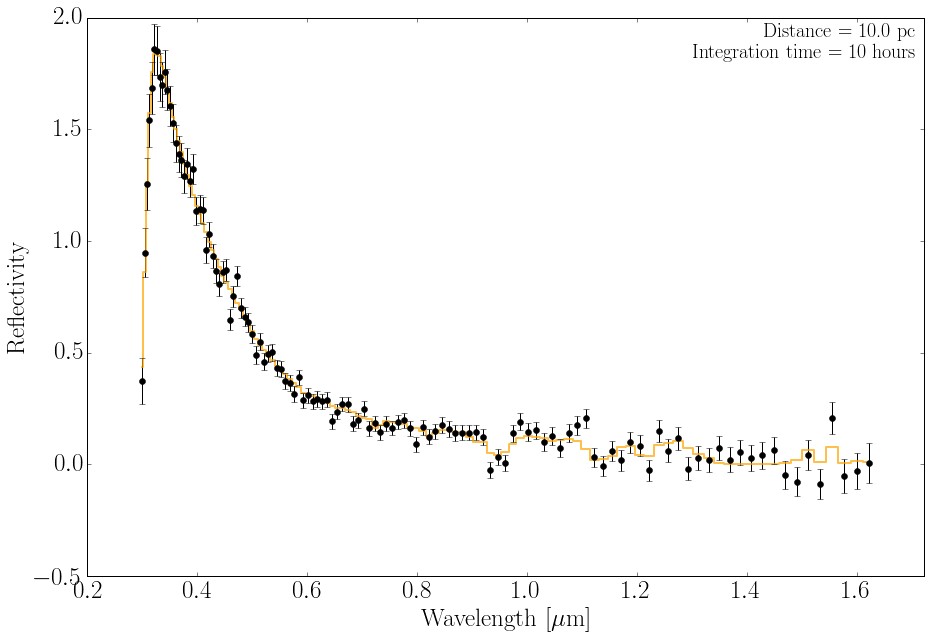

In [57]:
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 10.0, T, P, S, saveplot=False, savedata=False)

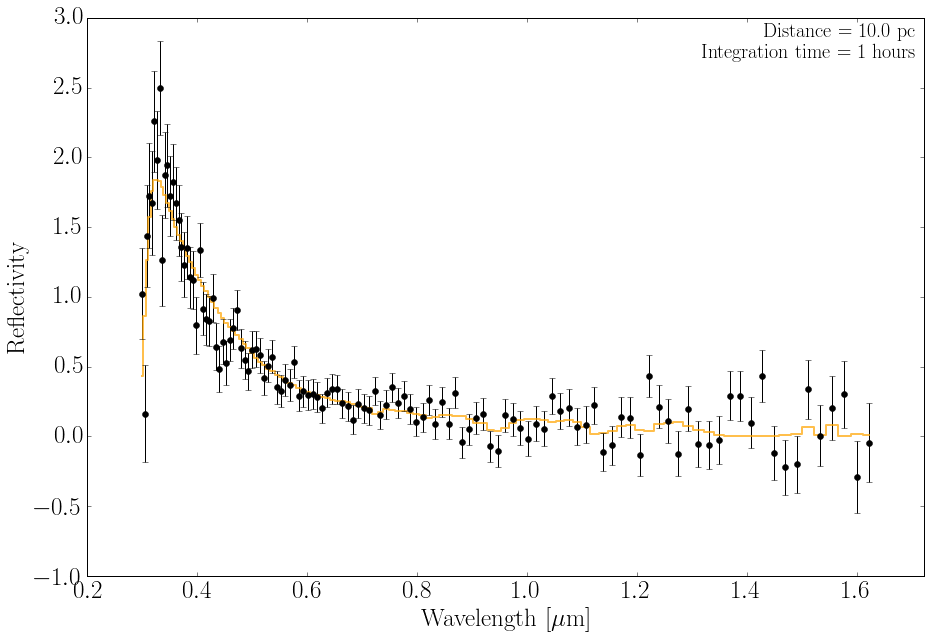

In [58]:
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 1.0, T, P, S, saveplot=False, savedata=False)

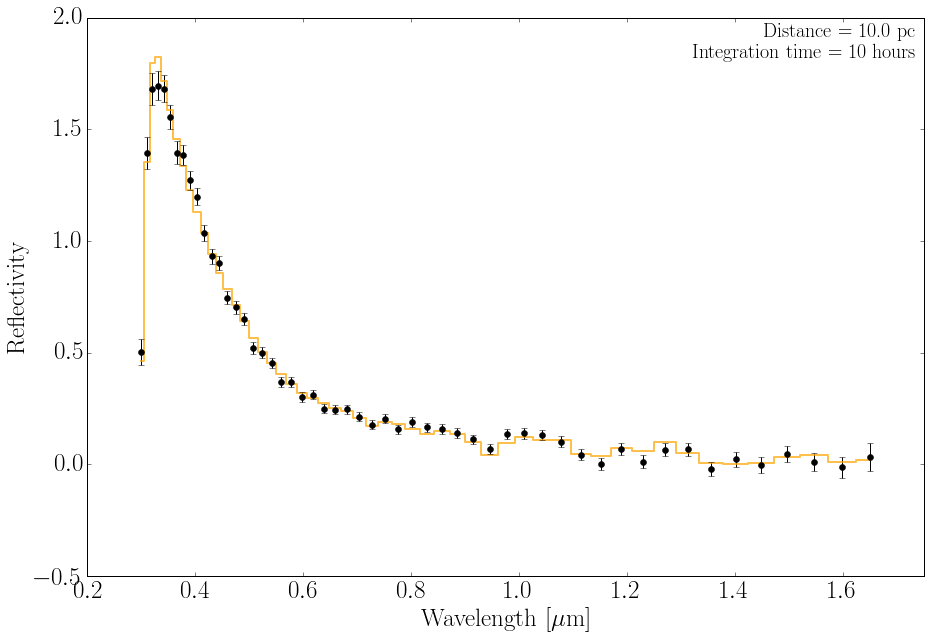

In [59]:
T.resolution = 30.0
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 10.0, T, P, S, saveplot=False, savedata=False)

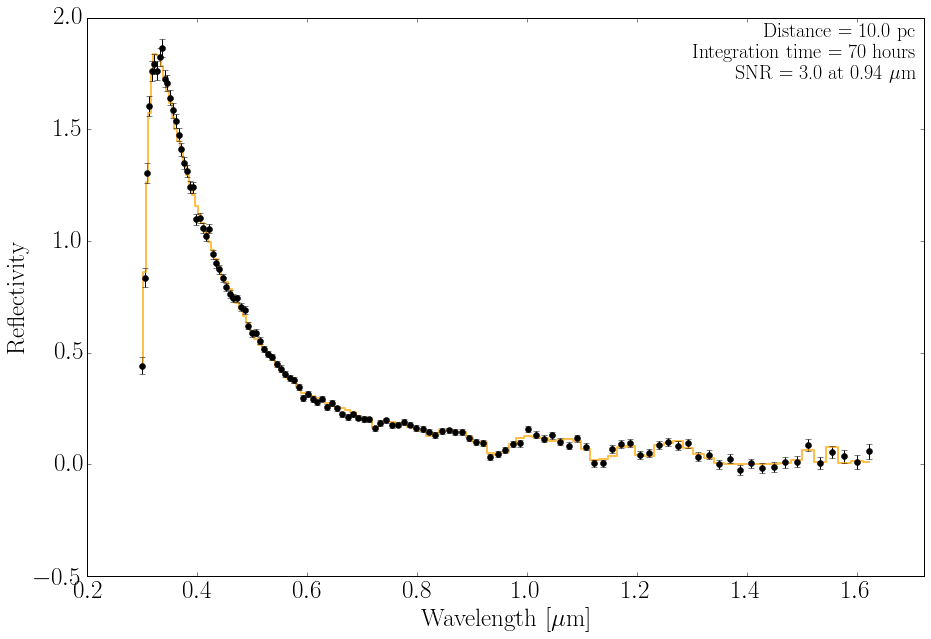

In [60]:
T.resolution = 70.0
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 70.0, T, P, S,\
                           saveplot=False, savedata=False, ref_lam=0.94)

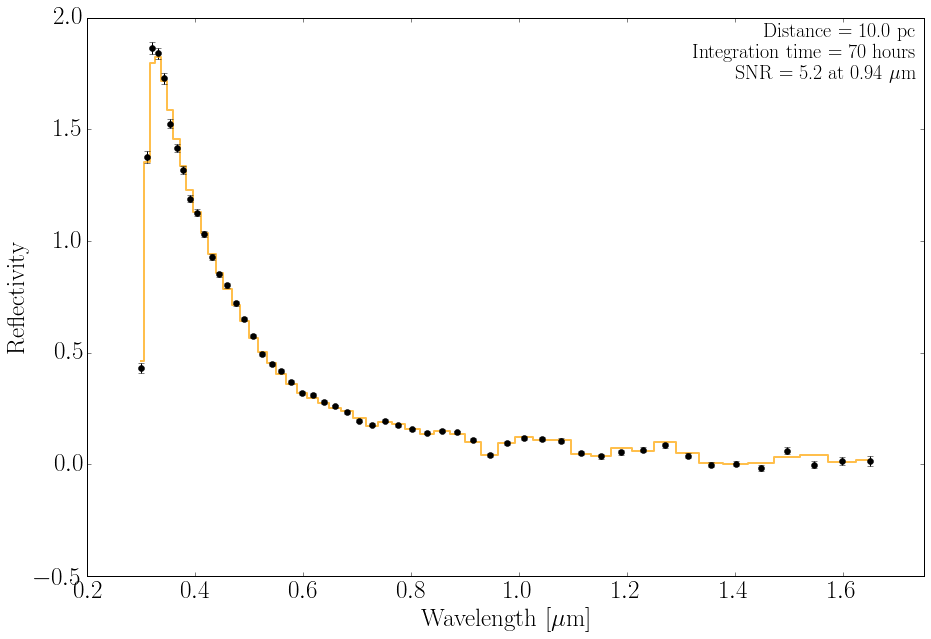

In [61]:
T.resolution = 30
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 70.0, T, P, S,\
                           saveplot=False, savedata=False, ref_lam=0.94)

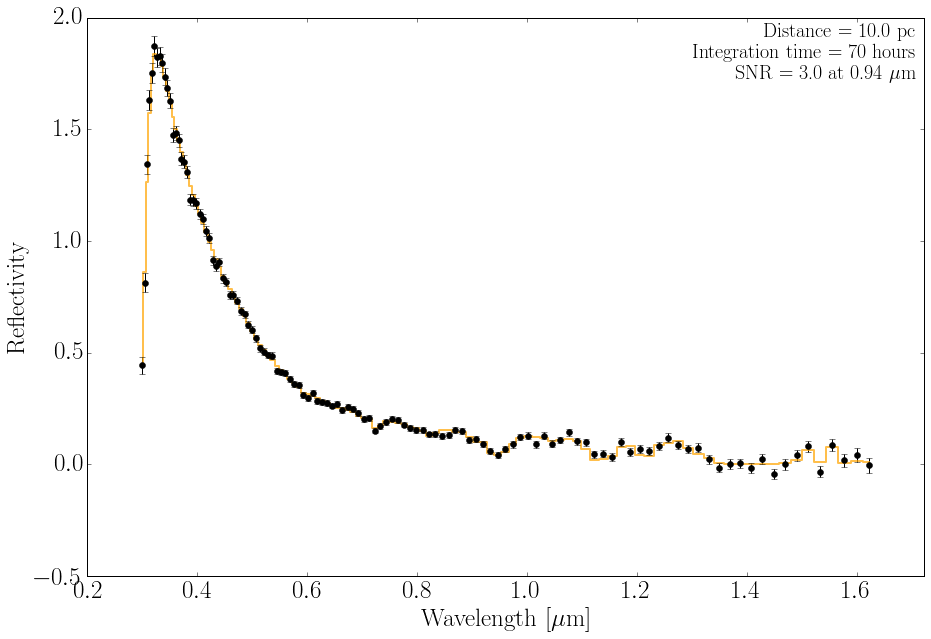

In [62]:
T.resolution = 70
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 70.0, T, P, S,\
                           saveplot=False, savedata=False, ref_lam=0.94)

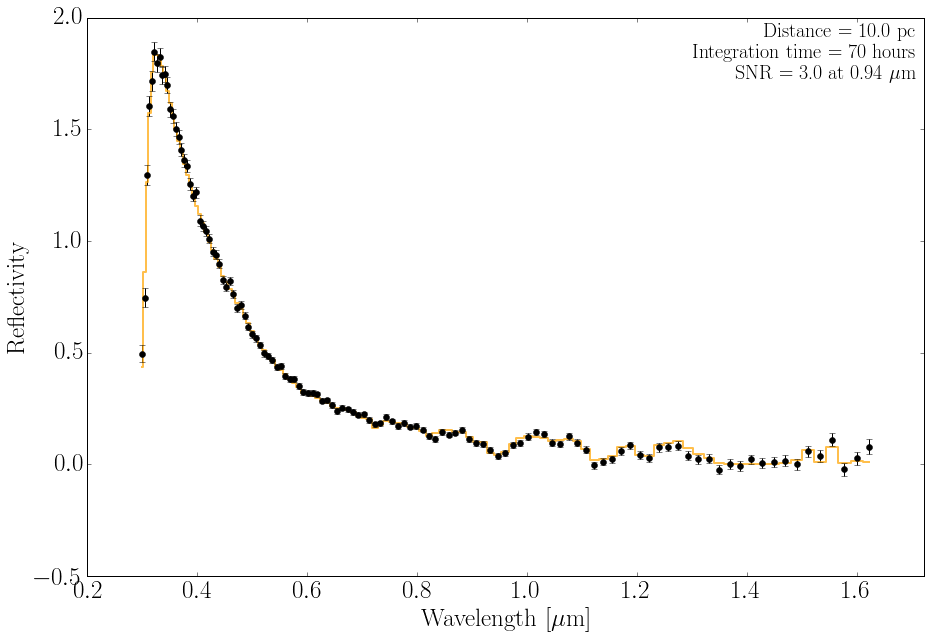

In [63]:
T.resolution = 70
P.alpha = 90.
dat = smart_observation('../planets/F2V_5.e-1fCO2_1.e6H2Volc_1.e10BIF.out_toa.rad', 70.0, T, P, S,\
                           saveplot=False, savedata=False, ref_lam=0.94)